<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°08

**Objetivo**: Aplicar técnicas de **machine learning no supervisado** para explorar, procesar y analizar conjuntos de datos con variables numéricas y categóricas.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


## Clustering


<img src="https://www.svgrepo.com/show/253022/car.svg" width = "300" align="center"/>



El conjunto de datos **`vehiculos_procesado_con_grupos.csv`** recopila información sobre diversas características relevantes de distintos vehículos. El propósito de este ejercicio es **clasificar los vehículos en diferentes categorías**, utilizando como base las variables descritas en la tabla de atributos.

El análisis presenta un desafío adicional debido a la **naturaleza mixta de los datos**: se incluyen tanto variables **numéricas** (ej. dimensiones, consumo, emisiones) como **categóricas** (ej. tipo de tracción, tipo de combustible), lo que requiere aplicar técnicas de preprocesamiento adecuadas antes de entrenar los modelos.

Como primer paso, procederemos a **cargar y explorar el conjunto de datos**, con el fin de familiarizarnos con su estructura y las características que servirán como base para la posterior clasificación.




**Descripción de los Datos:**

| **Nombre de la Columna**   | **Descripción**                                                                                                                                   |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **year**                   | El año en que el vehículo fue fabricado.                                                                                                          |
| **desplazamiento**          | La capacidad volumétrica del motor en litros. Indica la cantidad de aire y combustible que puede desplazar el motor durante una revolución.       |
| **cilindros**               | El número de cilindros que tiene el motor. Los cilindros son las cámaras donde ocurre la combustión interna en los motores de los vehículos.       |
| **co2**                     | Emisiones de dióxido de carbono del vehículo, medido en gramos por kilómetro. Es una medida de las emisiones de gases de efecto invernadero.       |
| **clase_tipo**              | La clase o tipo de vehículo, como vehículos especiales, deportivos, etc.                                                                         |
| **traccion_tipo**           | Tipo de tracción del vehículo, ya sea tracción en dos ruedas, en cuatro ruedas o en todas las ruedas.                                             |
| **transmision_tipo**        | Tipo de transmisión del vehículo, como automática, manual, entre otros.                                                                          |
| **combustible_tipo**        | Tipo de combustible que utiliza el vehículo, como gasolina, diésel, eléctrico, híbrido, etc.                                                     |
| **tamano_motor_tipo**       | Clasificación del tamaño del motor (por ejemplo, pequeño, mediano o grande), que generalmente se basa en la capacidad de desplazamiento.           |
| **consumo_tipo**            | Clasificación del nivel de consumo de combustible del vehículo, indicando si es alto, bajo, o muy alto.                                           |
| **co2_tipo**                | Clasificación de las emisiones de CO2 del vehículo, indicando si es alto, bajo, o muy alto.                                                       |
| **consumo_litros_milla**    | El consumo de combustible del vehículo, medido en litros por milla. Indica la eficiencia del vehículo en términos de consumo de combustible.        |



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans


%matplotlib inline

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
# cargar datos
df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/vehiculos_procesado_con_grupos.csv", sep=",")\
       .drop(
            ["fabricante",
             "modelo",
             "transmision",
             "traccion",
             "clase",
             "combustible",
             "consumo"],

          axis=1)

df.head()

En este caso, no solo se tienen datos numéricos, sino que también categóricos. Además, tenemos problemas de datos **vacíos (Nan)**. Así que para resolver este problema, seguiremos varios pasos:

### 1.- Normalizar datos

- Cree un conjunto de datos con las variables numéricas, además, para cada dato vacía, rellene con el promedio asociado a esa columna. Finalmente, normalize los datos mediante el procesamiento **MinMaxScaler** de **sklearn**.
- Cree un conjunto de datos con las variables categóricas , además, transforme de variables categoricas a numericas ocupando el comando **get_dummies** de pandas ([referencia](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)). Explique a grande rasgo como se realiza la codificación de variables numéricas a categóricas.

- Junte ambos dataset en uno, llamado **df_procesado**.

In [ ]:
# 1. Normalizar datos

#  Variables numéricas y categóricas
num_cols = ["year", "desplazamiento", "cilindros", "co2", "consumo_litros_milla"]
cat_cols = ["clase_tipo", "traccion_tipo", "transmision_tipo",
            "combustible_tipo", "tamano_motor_tipo", "consumo_tipo", "co2_tipo"]

# Datos numéricos
# Reemplazar valores faltantes (NaN) con el promedio de cada columna
df_num = df[num_cols].copy()
df_num = df_num.fillna(df_num.mean())

# Normalizar con MinMaxScaler (rango [0, 1])
scaler = MinMaxScaler()
df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns=num_cols)

# Datos categóricos
# Convertir variables categóricas a variables dummy (0/1)
df_cat = pd.get_dummies(df[cat_cols], drop_first=False)

# Unir ambos conjuntos
df_procesado = pd.concat([df_num_scaled, df_cat], axis=1)

# Mostrar resultado
print("Dimensiones del nuevo DataFrame procesado:", df_procesado.shape)
df_procesado.head()


### 2.- Realizar ajuste mediante kmeans

Una vez depurado el conjunto de datos, es momento de aplicar el algoritmo de **kmeans**.

1. Ajuste el modelo de **kmeans** sobre el conjunto de datos, con un total de **8 clusters**.
2. Asociar a cada individuo el correspondiente cluster y calcular valor de los centroides de cada cluster.
3. Realizar un resumen de las principales cualidades de cada cluster. Para  esto debe calcular (para cluster) las siguientes medidas de resumen:
    * Valor promedio de las variables numérica
    * Moda para las variables numericas

In [ ]:
# 2. Realizar ajuste mediante KMeans

# 1. Ajuste del modelo
# Creamos el modelo con 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)

# Ajustamos el modelo sobre los datos procesados
kmeans.fit(df_procesado)

# 2. Asociar cada observación a un cluster
df_procesado["cluster"] = kmeans.labels_

# 3. Resumen por cluster
# a) Promedio de variables numéricas
cluster_mean = df_procesado.groupby("cluster")[["year", "desplazamiento", "cilindros", "co2", "consumo_litros_milla"]].mean()

# b) Moda (valor más frecuente) para las categóricas
# Seleccionamos solo las columnas categóricas (todas las que no sean numéricas)
cat_cols = [c for c in df_procesado.columns if c not in ["year", "desplazamiento", "cilindros", "co2", "consumo_litros_milla", "cluster"]]

cluster_mode = df_procesado.groupby("cluster")[cat_cols].agg(lambda x: x.mode().iloc[0])

# Unimos ambos resúmenes
resumen_clusters = pd.concat([cluster_mean, cluster_mode], axis=1)

# Mostrar resultados
print("Centroides numéricos de cada cluster:\n")
display(cluster_mean)

print("\nResumen de principales cualidades por cluster:\n")
display(resumen_clusters.head(8))


### 3.- Elegir Número de cluster

Estime mediante la **regla del codo**, el número de cluster apropiados para el caso.
Para efectos prácticos, eliga la siguiente secuencia como número de clusters a comparar:

$$[5, 10, 20, 30, 50, 75, 100, 200, 300]$$

Una vez realizado el gráfico, saque sus propias conclusiones del caso.

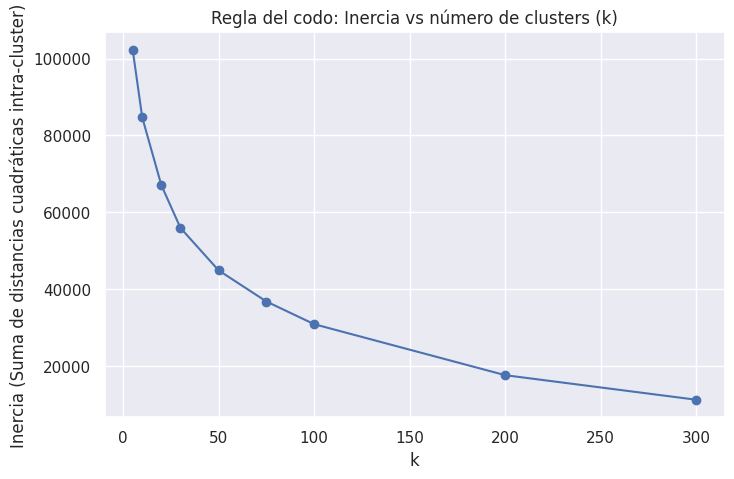

,k,inercia,mejora_rel_vs_k_prev
0,5,102310.085717,NaN
1,10,84705.942260,0.172067
2,20,67073.433922,0.208161
3,30,55953.931718,0.165781
4,50,44887.890355,0.197771
5,75,36797.322699,0.180239
6,100,30896.217764,0.160368
7,200,17625.993510,0.429510
8,300,11234.817895,0.362599


In [45]:

X = df_procesado.drop(columns=['cluster']) if 'cluster' in df_procesado.columns else df_procesado

# Asegurar tipo numérico (por si quedaron booleanos)
X = X.astype(float)

ks = [5, 10, 20, 30, 50, 75, 100, 200, 300]
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)

# Gráfico del codo
plt.figure(figsize=(8,5))
plt.plot(ks, inertias, marker='o')
plt.title('Regla del codo: Inercia vs número de clusters (k)')
plt.xlabel('k')
plt.ylabel('Inercia (Suma de distancias cuadráticas intra-cluster)')
plt.grid(True)
plt.show()

# Tablita de mejoras relativas
mejora_rel = [np.nan] + list((np.array(inertias[:-1]) - np.array(inertias[1:])) / np.array(inertias[:-1]))
tabla = pd.DataFrame({'k': ks, 'inercia': inertias, 'mejora_rel_vs_k_prev': mejora_rel})
display(tabla)


Al observar el gráfico resultante, se pueden obtener conclusiones sobre el número apropiado de clusters. La regla del codo sugiere elegir el número de clusters donde la reducción en la inercia se estabiliza significativamente. En otras palabras, se busca el punto en el gráfico donde la curva de inercia comienza a aplanarse o forma un codo.

## Reducción de Dimensionalidad

<img src="https://1000logos.net/wp-content/uploads/2020/11/Wine-Logo-old.png" width = "300" align="center"/>


Para este ejercicio utilizaremos el **Wine Dataset**, un conjunto de datos clásico disponible en la librería **scikit-learn** y en el repositorio de la **UCI Machine Learning**.
Este dataset contiene información de **178 muestras de vino** provenientes de la región italiana de *Piamonte*. Cada vino pertenece a una de **tres variedades de uva** (*clases*), que actúan como etiquetas para el análisis supervisado, pero aquí se usarán solo como referencia en la visualización.

Cada muestra está descrita por **13 variables químicas** obtenidas de un análisis de laboratorio, entre ellas:

* **Alcohol**: porcentaje de alcohol en el vino.
* **Malic acid**: concentración de ácido málico.
* **Ash**: contenido de ceniza.
* **Alcalinity of ash**: alcalinidad de la ceniza.
* **Magnesium**: cantidad de magnesio (mg/L).
* **Total phenols**: concentración total de fenoles.
* **Flavanoids**: tipo de fenoles con propiedades antioxidantes.
* **Nonflavanoid phenols**: fenoles que no son flavonoides.
* **Proanthocyanins**: compuestos relacionados con el color y el sabor.
* **Color intensity**: intensidad del color del vino.
* **Hue**: matiz del color.
* **OD280/OD315 of diluted wines**: relación de absorbancia que mide la calidad del vino.
* **Proline**: concentración de prolina (un aminoácido).

Estas características permiten representar cada vino como un punto en un espacio de **13 dimensiones**.

El objetivo del análisis con este dataset es **reducir la dimensionalidad** para visualizar y explorar patrones en los datos. Para ello aplicaremos:

* **PCA (Principal Component Analysis):** identificar las combinaciones lineales de variables que explican la mayor varianza en el conjunto.
* **t-SNE (t-distributed Stochastic Neighbor Embedding):** mapear las muestras a 2D o 3D, preservando relaciones de vecindad y estructuras no lineales.

La comparación entre ambas técnicas permitirá observar cómo las tres clases de vinos se diferencian en el espacio reducido y discutir la utilidad de la reducción de dimensionalidad en datos con mayor número de variables que en el caso del dataset *Wine*.



In [46]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [47]:
# cargar dataset
dataset = load_wine()

# nombres de las variables
features = dataset.feature_names
target = 'wine_class'

# construir DataFrame
wine = pd.DataFrame(dataset.data, columns=features)
wine[target] = dataset.target

# ver primeras filas
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0




### 1. **Análisis detallado con PCA**

* Calcular la **varianza explicada** por cada componente principal y representar el gráfico de varianza acumulada, identificando cuántos componentes son necesarios para capturar al menos el **90–95% de la información**.
* Construir tablas y gráficos que muestren cómo las observaciones (vinos) se proyectan en las primeras componentes principales.
* Analizar los **loadings** (coeficientes de cada variable en los componentes) e interpretar qué características químicas del vino (alcohol, fenoles, color, etc.) tienen mayor influencia en las nuevas dimensiones.
* Visualizar los datos reducidos a 2D o 3D e interpretar si las **tres variedades de vino** se separan de forma clara en el espacio proyectado.



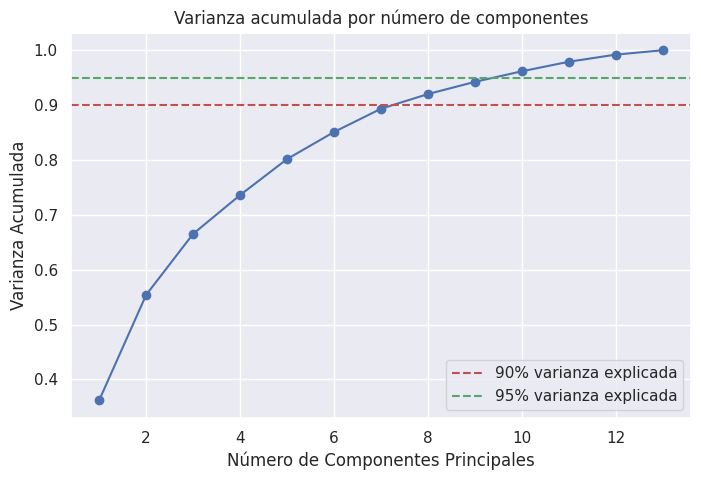

,Componente,Varianza_Explicada,Varianza_Acumulada
0,PC1,0.361988,0.361988
1,PC2,0.192075,0.554063
2,PC3,0.111236,0.665300
3,PC4,0.070690,0.735990
4,PC5,0.065633,0.801623
5,PC6,0.049358,0.850981
6,PC7,0.042387,0.893368
7,PC8,0.026807,0.920175
8,PC9,0.022222,0.942397
9,PC10,0.019300,0.961697



Top variables con mayor influencia en PC1 y PC2:


,PC1,PC2
flavanoids,0.422934,-0.003360
total_phenols,0.394661,0.065040
od280/od315_of_diluted_wines,0.376167,-0.164496
proanthocyanins,0.313429,0.039302
hue,0.296715,-0.279235


,PC1,PC2
color_intensity,-0.088617,0.529996
alcohol,0.144329,0.483652
proline,0.286752,0.364903
ash,-0.002051,0.316069
magnesium,0.141992,0.299634


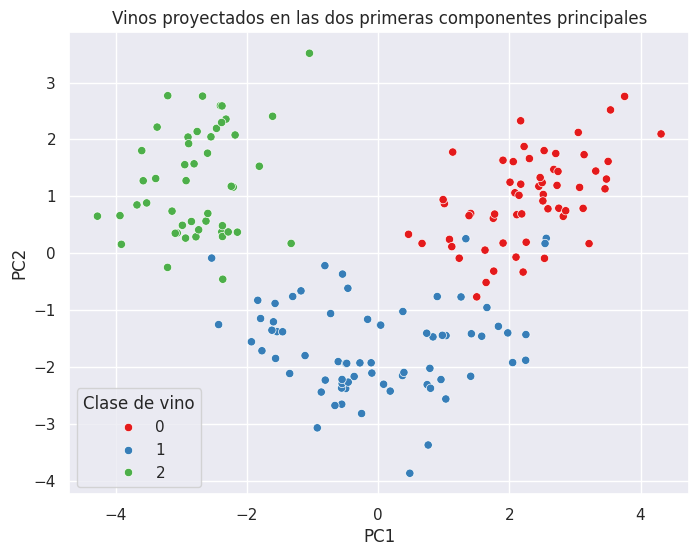

In [51]:
from sklearn.preprocessing import StandardScaler
# Escalamiento de los datos
X = wine.drop(columns=['wine_class'])
y = wine['wine_class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 1. Varianza explicada
var_exp = pca.explained_variance_ratio_
var_exp_acum = var_exp.cumsum()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_exp)+1), var_exp_acum, marker='o', linestyle='-')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% varianza explicada')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% varianza explicada')
plt.title('Varianza acumulada por número de componentes')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar tabla de varianza explicada
var_table = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(var_exp))],
    'Varianza_Explicada': var_exp,
    'Varianza_Acumulada': var_exp_acum
})
display(var_table.head(10))

# 2. Loadings (contribución de cada variable a cada componente)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=X.columns
)

# Mostrar las 5 variables más influyentes en las dos primeras componentes
print("\nTop variables con mayor influencia en PC1 y PC2:")
display(loadings[['PC1', 'PC2']].sort_values(by='PC1', ascending=False).head(5))
display(loadings[['PC1', 'PC2']].sort_values(by='PC2', ascending=False).head(5))

# 3. Visualización de los vinos en las dos primeras componentes
df_pca = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
df_pca['wine_class'] = y

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='wine_class', palette='Set1')
plt.title('Vinos proyectados en las dos primeras componentes principales')
plt.legend(title='Clase de vino')
plt.show()




### 2. **Análisis detallado con t-SNE**

* Aplicar **t-SNE** para reducir los datos a 2 dimensiones, probando diferentes configuraciones de hiperparámetros como *perplexity* y *learning rate*.
* Comparar las distintas visualizaciones obtenidas y discutir cómo los hiperparámetros afectan la estructura de los clústeres.
* Analizar si las **tres clases de vinos** forman agrupaciones definidas y si t-SNE logra capturar relaciones no lineales que PCA no refleja.



/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarnin

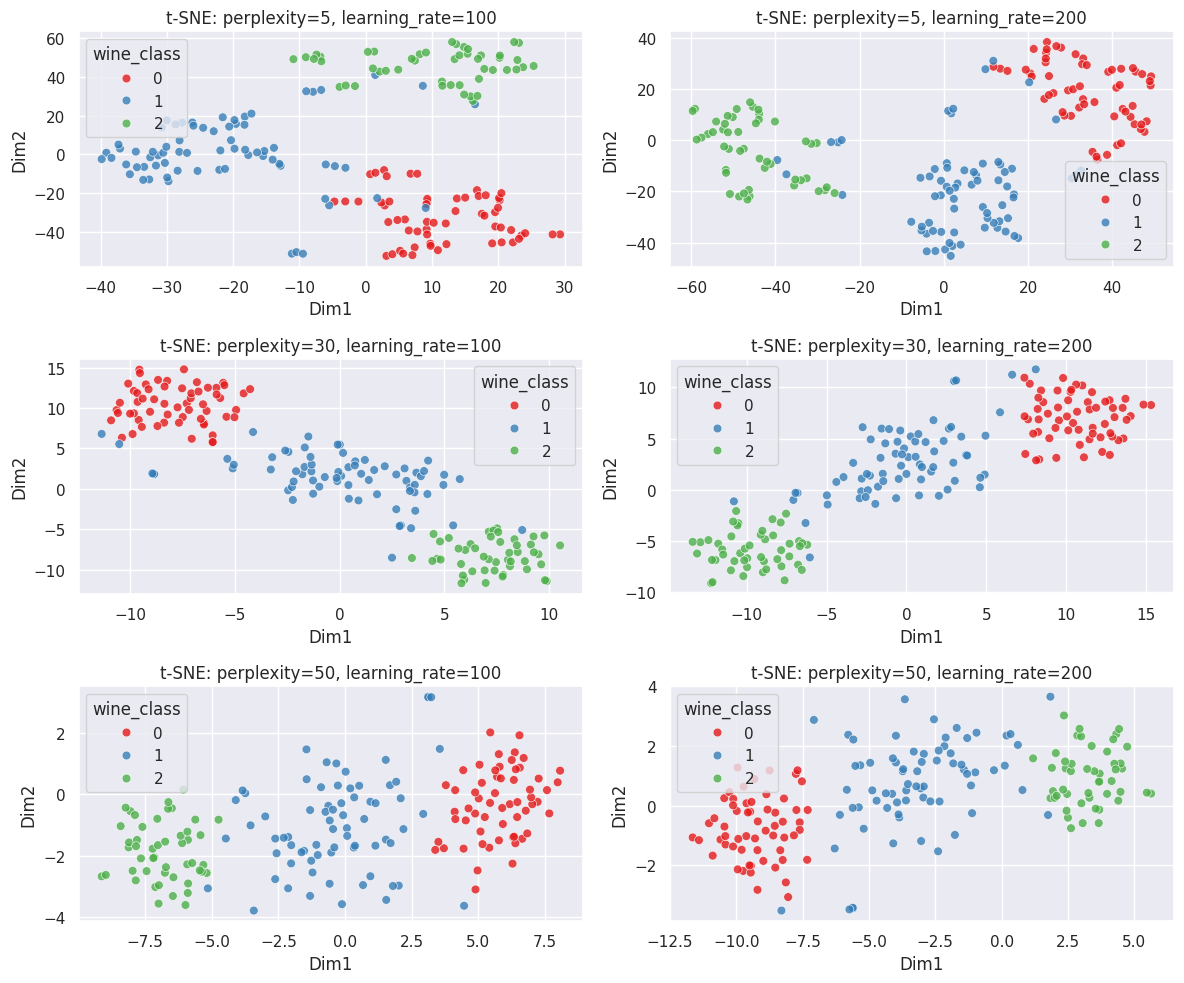

In [52]:
# Datos ya escalados del PCA ---
X = wine.drop(columns=['wine_class'])
y = wine['wine_class']

# Escalado nuevamente (por si no lo tienes activo en memoria)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Probar diferentes configuraciones
perplexities = [5, 30, 50]
learning_rates = [100, 200]

fig, axes = plt.subplots(len(perplexities), len(learning_rates), figsize=(12,10))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(
            n_components=2,
            perplexity=perp,
            learning_rate=lr,
            n_iter=1000,
            random_state=42
        )
        X_tsne = tsne.fit_transform(X_scaled)
        df_tsne = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
        df_tsne['wine_class'] = y

        sns.scatterplot(
            data=df_tsne, x='Dim1', y='Dim2', hue='wine_class',
            palette='Set1', ax=axes[i, j], s=40, alpha=0.8
        )
        axes[i, j].set_title(f"t-SNE: perplexity={perp}, learning_rate={lr}")

plt.tight_layout()
plt.show()




### 3. **Comparación entre PCA y t-SNE**

* Contrastar las visualizaciones y discutir las **ventajas y limitaciones** de cada técnica:

  * PCA como método **lineal** para interpretar varianza y relaciones globales.
  * t-SNE como método **no lineal** que preserva relaciones locales y vecindades.
* Evaluar en qué escenarios prácticos sería más recomendable usar PCA (interpretabilidad, reducción previa para modelos) o t-SNE (exploración y visualización de clústeres).
* Reflexionar sobre la **importancia de la reducción de dimensionalidad** en datasets de alta dimensión como Wine, destacando su utilidad para:

  * Visualizar patrones ocultos en los datos.
  * Reducir complejidad y ruido antes de aplicar algoritmos de aprendizaje automático.
  * Facilitar la interpretación y comunicación de resultados.



/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


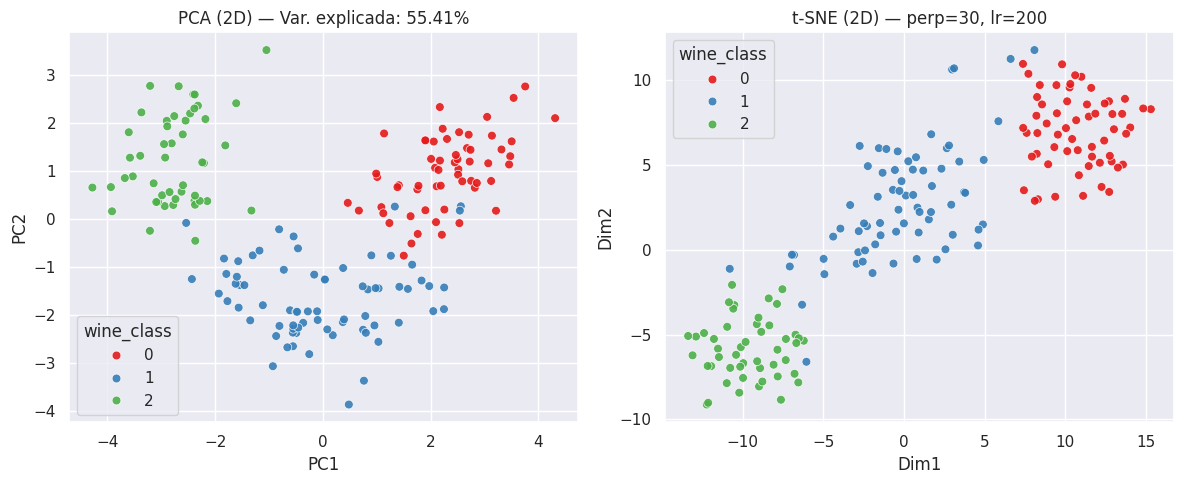

Varianza explicada PCA (2D): 0.5541
Trustworthiness PCA (k=10):  0.8877
Trustworthiness t-SNE (k=10): 0.9578


In [54]:
# Comparación PCA vs t-SNE: visualización + métricas clave
# (1) Visualizaciones lado a lado
# (2) Métricas para discutir ventajas/limitaciones
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, trustworthiness

# Datos y escalado
X = wine.drop(columns=['wine_class'])
y = wine['wine_class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA (2 componentes)
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)
pca_var_2 = pca2.explained_variance_ratio_.sum()  # varianza explicada por PC1+PC2

# t-SNE (mejores hiperparámetros que te funcionaron)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_tsne2 = tsne.fit_transform(X_scaled)

# Visualizaciones comparables
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=y, palette='Set1', ax=axes[0], s=40, alpha=0.9)
axes[0].set_title(f'PCA (2D) — Var. explicada: {pca_var_2:.2%}')
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2'); axes[0].legend(title='wine_class')

sns.scatterplot(x=X_tsne2[:,0], y=X_tsne2[:,1], hue=y, palette='Set1', ax=axes[1], s=40, alpha=0.9)
axes[1].set_title('t-SNE (2D) — perp=30, lr=200')
axes[1].set_xlabel('Dim1'); axes[1].set_ylabel('Dim2'); axes[1].legend(title='wine_class')

plt.tight_layout()
plt.show()

# Métricas para discutir ventajas/limitaciones
# Trustworthiness: cuán bien se preservan vecindarios (más alto es mejor)
tw_pca  = trustworthiness(X_scaled, X_pca2, n_neighbors=10)
tw_tsne = trustworthiness(X_scaled, X_tsne2, n_neighbors=10)

print(f"Varianza explicada PCA (2D): {pca_var_2:.4f}")
print(f"Trustworthiness PCA (k=10):  {tw_pca:.4f}")
print(f"Trustworthiness t-SNE (k=10): {tw_tsne:.4f}")


En términos prácticos, PCA resulta más recomendable cuando se busca una reducción interpretable y cuantitativa, útil como paso previo para modelos de aprendizaje automático o para explicar la varianza de los datos. Por otro lado, t-SNE es ideal para la exploración visual y la identificación de agrupaciones no lineales, ya que preserva relaciones locales y vecindades entre muestras.

La reducción de dimensionalidad es fundamental en conjuntos de alta dimensión como Wine, ya que permite visualizar patrones ocultos, disminuir la complejidad y el ruido antes del modelado y facilitar la interpretación y comunicación de resultados, transformando datos difíciles de analizar en representaciones más claras y comprensibles.